In [115]:
import os
import re
import pandas as pd
import numpy as np
#pre processamento
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#glove
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
#modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import tensorflow as tf
#avalição
from sklearn.metrics import classification_report, confusion_matrix
#plot
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Impotação da Base de dados

In [117]:
df = pd.read_csv('DATA/WELFake_Dataset.csv')
df.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)
df.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Tratamento dos dados

In [118]:
def process_df(df):
    df.dropna(inplace=True) #removendo valores nulos
    df.drop_duplicates(subset='text', keep='last', inplace=True) #removendo duplicatas
    df.reset_index(drop=True, inplace=True) #resetando index
    df['text'] = df['text'].apply(lambda text: re.sub(r"[^A-Za-z0-9\s\.]", '', text.lower())) #removendo caracteres especiais
    return df

df = process_df(df)
print(df.shape)
print(df['label'].value_counts()) #1 real 0 fake

(62718, 2)
0    34620
1    28098
Name: label, dtype: int64


## PROCESSAMENTO DE LINGUAGEM NATURAL (PLN)

Tokenização, Stop Words, Lematização

In [119]:
def process_data(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text) #tokenização
    tokens = [token for token in tokens if token not in stop_words] #remoção de stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #lematização
    preprocessed_text = ' '.join(tokens) #junção de tokens
    
    return preprocessed_text

TF-IDF

In [120]:
def calculate_tfidf(text):
    vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = vectorizer.fit_transform(text) 
    return tfidf_matrix.toarray()

GloVe

In [121]:
#Carregando Stanford GloVe mode
glove_filename = 'DATA/glove.6b/glove.6B.100d.txt' 
glove_path = os.path.abspath(glove_filename)
word2vec_output_file = glove_filename +'.word2vec'
glove2word2vec(glove_path, word2vec_output_file) #convertendo GloVe para word2vec
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) 

#Calculando GloVe
def calculate_glove(text):
    vectorizer = Word2VecVectorizer(glove_model)
    glove_matrix = vectorizer.fit_transform(text) #calculando GloVe
    return glove_matrix

#Classe para vetorização de textos
class Word2VecVectorizer:
    def __init__(self, model):
        self.word_vectors = model
        self.D = model.vector_size

    def fit(self, data):
        pass

    def transform(self, data):
        X = np.zeros((len(data), self.D))
        emptycount = 0
        for i, sentence in enumerate(data):
            tokens = sentence.split()
            vecs = []
            for word in tokens:
                try:
                    vec = self.word_vectors[word]
                    vecs.append(vec)
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[i] = vecs.mean(axis=0)
            else:
                emptycount += 1
        print("Número de amostras sem palavras encontradas: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

Aplicação do PLN

In [122]:
#aplicando tokenização, stopWords, lematização
df['tokens'] = df['text'].apply(process_data)

#TF-IDF
tfidf = calculate_tfidf(df['tokens'])

#GloVe
glove = calculate_glove(df['tokens'])

Número de amostras sem palavras encontradas: 65 / 62718


Divisão de dados em treinamento e teste

In [123]:
# TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf, df['label'], test_size=0.2, random_state=42)

#GloVe
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(glove, df['label'], test_size=0.2, random_state=42)

## MODELOS CLASSIFICADORES

Naive Bayes

In [124]:
def naive_bayes_model(X_train, y_train, X_test):
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(X_train, y_train) #treinando modelo
    y_pred = gaussian_nb.predict(X_test) #fazendo predição
    return y_pred

Floresta Aleatória

In [125]:
def random_forest_model(X_train, y_train, X_test):
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train) #treinando modelo
    y_pred = random_forest.predict(X_test) #testando modelo
    return y_pred

Support Vector Machine

In [126]:
def support_vector_machine_model(X_train, y_train, X_test):
    svm = LinearSVC()
    svm.fit(X_train, y_train) #treinando modelo
    y_pred = svm.predict(X_test) #testando modelo
    return y_pred

Rede Neural

In [127]:
def neural_network_model(X_train, y_train, X_test):
    model = tf.keras.models.Sequential([ #definindo modelo
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compilando modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0) #treinando modelo
    y_pred = model.predict(X_test) #testando modelo
    y_pred = (y_pred > 0.5).astype(int) #convertendo valores para 0 ou 1
    
    return y_pred

Aplicação dos modelos

In [128]:
#TF-IDF
nb_model_tfidf = naive_bayes_model(X_train_tfidf, y_train_tfidf, X_test_tfidf)
rf_model_tfidf = random_forest_model(X_train_tfidf, y_train_tfidf, X_test_tfidf)
svm_model_tfidf = support_vector_machine_model(X_train_tfidf, y_train_tfidf, X_test_tfidf)
nn_model_tfidf = neural_network_model(X_train_tfidf, y_train_tfidf, X_test_tfidf)

#GloVe
nb_model_glove = naive_bayes_model(X_train_glove, y_train_glove, X_test_glove)
rf_model_glove = random_forest_model(X_train_glove, y_train_glove, X_test_glove)
svm_model_glove = support_vector_machine_model(X_train_glove, y_train_glove, X_test_glove)
nn_model_glove = neural_network_model(X_train_glove, y_train_glove, X_test_glove)

392/392 [==============================] - 1s 1ms/step


## Métricas de Avaliação

Matriz de confusão

In [129]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred) #calculando matriz de confusão
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d') #plotando matriz 
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

Acurácia, Precisão, Recall, F1-score

Resultados pre-processados pelo TF-IDF:


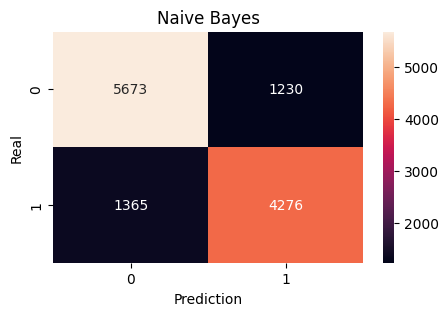

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      6903
           1       0.78      0.76      0.77      5641

    accuracy                           0.79     12544
   macro avg       0.79      0.79      0.79     12544
weighted avg       0.79      0.79      0.79     12544



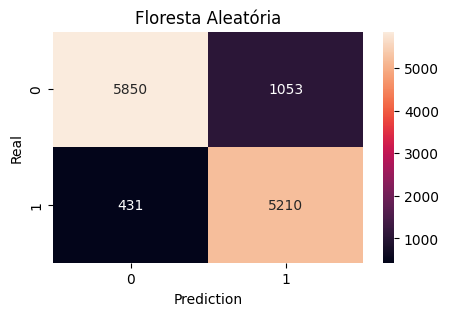

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      6903
           1       0.83      0.92      0.88      5641

    accuracy                           0.88     12544
   macro avg       0.88      0.89      0.88     12544
weighted avg       0.89      0.88      0.88     12544



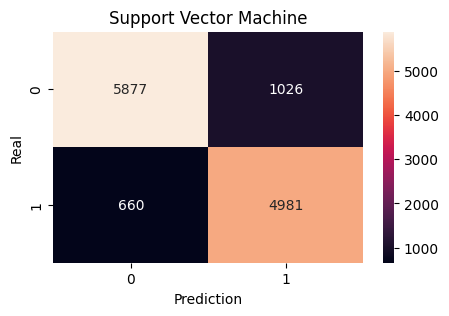

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      6903
           1       0.83      0.88      0.86      5641

    accuracy                           0.87     12544
   macro avg       0.86      0.87      0.86     12544
weighted avg       0.87      0.87      0.87     12544



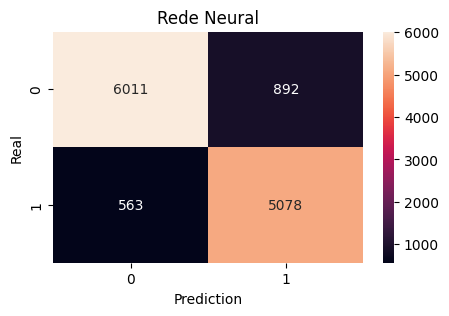

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6903
           1       0.85      0.90      0.87      5641

    accuracy                           0.88     12544
   macro avg       0.88      0.89      0.88     12544
weighted avg       0.89      0.88      0.88     12544


Resultados pre-processados pelo GloVe:


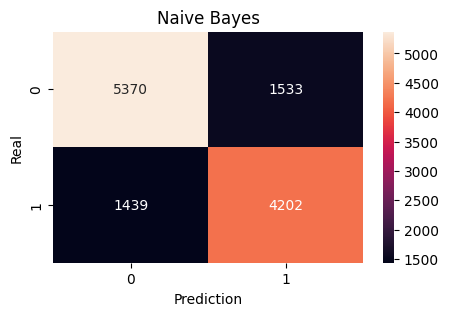

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6903
           1       0.73      0.74      0.74      5641

    accuracy                           0.76     12544
   macro avg       0.76      0.76      0.76     12544
weighted avg       0.76      0.76      0.76     12544



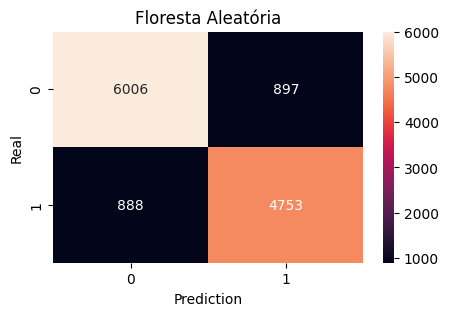

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      6903
           1       0.84      0.84      0.84      5641

    accuracy                           0.86     12544
   macro avg       0.86      0.86      0.86     12544
weighted avg       0.86      0.86      0.86     12544



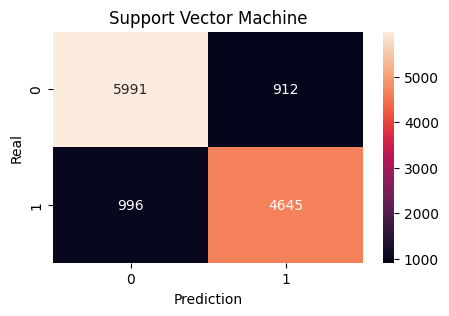

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      6903
           1       0.84      0.82      0.83      5641

    accuracy                           0.85     12544
   macro avg       0.85      0.85      0.85     12544
weighted avg       0.85      0.85      0.85     12544



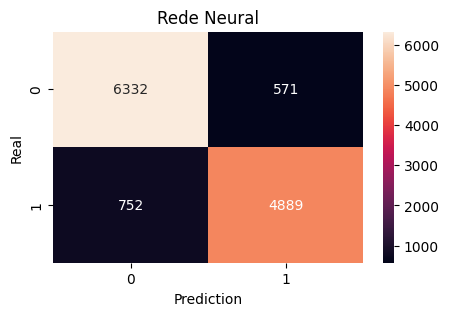

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      6903
           1       0.90      0.87      0.88      5641

    accuracy                           0.89     12544
   macro avg       0.89      0.89      0.89     12544
weighted avg       0.89      0.89      0.89     12544



In [130]:
print("Resultados pre-processados pelo TF-IDF:")
plot_confusion_matrix(y_test_tfidf, nb_model_tfidf, 'Naive Bayes')
print(classification_report(y_test_tfidf, nb_model_tfidf))
plot_confusion_matrix(y_test_tfidf, rf_model_tfidf, 'Floresta Aleatória')
print(classification_report(y_test_tfidf, rf_model_tfidf))
plot_confusion_matrix(y_test_tfidf, svm_model_tfidf, 'Support Vector Machine')
print(classification_report(y_test_tfidf, svm_model_tfidf))
plot_confusion_matrix(y_test_tfidf, nn_model_tfidf, 'Rede Neural')
print(classification_report(y_test_tfidf, nn_model_tfidf))

print("\nResultados pre-processados pelo GloVe:")
plot_confusion_matrix(y_test_glove, nb_model_glove, 'Naive Bayes')
print(classification_report(y_test_glove, nb_model_glove))
plot_confusion_matrix(y_test_glove, rf_model_glove, 'Floresta Aleatória')
print(classification_report(y_test_glove, rf_model_glove))
plot_confusion_matrix(y_test_glove, svm_model_glove, 'Support Vector Machine')
print(classification_report(y_test_glove, svm_model_glove))
plot_confusion_matrix(y_test_glove, nn_model_glove, 'Rede Neural')
print(classification_report(y_test_glove, nn_model_glove))